In [ ]:
%pip install gpytorch;

In [10]:
import xarray as xr
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Make a toy dataset

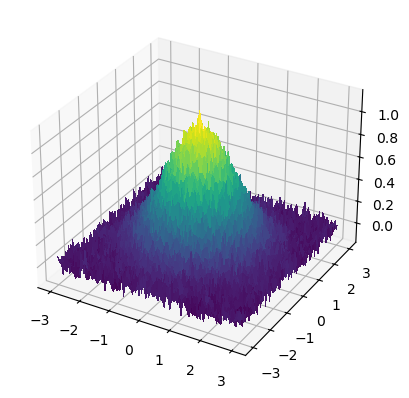

In [55]:
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, noise):
    z = np.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))
    return z + np.random.normal(size=z.shape) * noise

def make_test_dataset(size, x0, y0, sigma_x, sigma_y, noise):
    x = np.linspace(-3, 3, size)
    y = np.linspace(-3, 3, size)

    x, y = np.meshgrid(x, y)

    z = gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, noise)

    return x, y, z

x, y, z = make_test_dataset(100, 0, 0, 1, 1, 0.05)

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(x, y, z, cmap="viridis",
                       linewidth=0, antialiased=False)

plt.show()

## Compute empirical variogram

In [56]:
x_sample = x.flatten()
y_sample = y.flatten()
z_sample = z.flatten()

# Shuffle to create point pairs - this isn't all pairs but
# should be a reasonable approximation
shuffled = np.stack([x_sample, y_sample, z_sample], axis=-1)
np.random.shuffle(shuffled)
x_shuffle = shuffled[:, 0]
y_shuffle = shuffled[:, 1]
z_shuffle = shuffled[:, 2]

d  = ((x_sample - x_shuffle)**2 + (y_sample - y_shuffle)**2)**0.5
dz = (z_sample - z_shuffle)**2

sum_d, edges  = np.histogram(d, weights=dz, bins=100)
n_d, edges = np.histogram(d, bins=100)
mean_d = sum_d / (n_d+1) # prevent division by zero

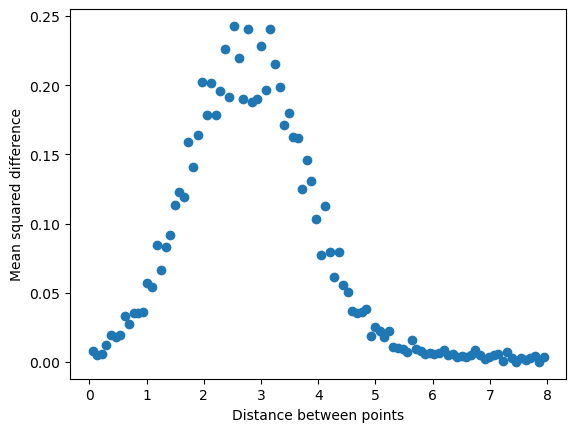

In [57]:
plt.scatter(edges[:-1], mean_d)
plt.ylabel("Mean squared difference")
plt.xlabel("Distance between points")
plt.show()

This is a very idealized case where a Matern kernel should work well.

## Training functions

In [147]:
import torch
import time
import gpytorch
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import warnings
warnings.filterwarnings("ignore")

In [144]:
# Gpytorch versions
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModelGrid(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelGrid, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.MaternKernel(), grid_size=grid_size, num_dims=2
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gpytorch_model(xy_tensor, z_tensor, use_structure=False, use_gpu=False, n_iter=10):
    ModelClass = ExactGPModelGrid if use_structure else ExactGPModel

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ModelClass(xy_tensor, z_tensor, likelihood)

    if use_gpu:
        xy_tensor = xy_tensor.cuda()
        z_tensor = z_tensor.cuda()
        model = model.cuda()    
        likelihood = likelihood.cuda()
    else:
        xy_tensor = xy_tensor.cpu()
        z_tensor = z_tensor.cpu()
        model = model.cpu()
        likelihood = likelihood.cpu()

    # Transition to train mode
    model.train()
    likelihood.train()

    # Set up optimizter and log-likelihood
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    t0 = time.time()
    for _ in tqdm(range(n_iter)):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(xy_tensor)
        # Calc loss and backprop gradients
        loss = -mll(output, z_tensor)
        loss.backward()
    tf = time.time()
    elapsed = tf - t0

    return model, elapsed

# Too slow!

#def train_scikit_model(xy_arr, z_arr, n_iter=10):
#    kernel = Matern(length_scale=4.0, nu=2.5)
#    
#    # n_restarts = 0 implies 1 run
#    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_iter-1,
#                                               optimizer="adam")
#    gaussian_process.fit(xy_arr, z_arr)
#    return gaussian_process



In [132]:
# Convert the toy dataset to tensors/numpy arrays for compatability
# Note that the structure-exploiting kernel *must* be given float32 tensors
xy_arr    = np.stack([x.flatten(), y.flatten()], axis=-1).astype(np.float32)
z_arr     = z.flatten().astype(np.float32)
xy_tensor = torch.from_numpy(xy_arr)
z_tensor  = torch.from_numpy(z_arr)

Verify that all the models successfully train.

In [133]:
model1 = train_gpytorch_model(xy_tensor, z_tensor)

100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


In [134]:
model2 = train_gpytorch_model(xy_tensor, z_tensor, use_gpu=True)

100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


In [138]:
model3 = train_gpytorch_model(xy_tensor, z_tensor, use_structure=True)

100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


In [137]:
model4 = train_gpytorch_model(xy_tensor, z_tensor, use_structure=True, use_gpu=True)

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


## Benchmark on different dataset sizes

In [ ]:
sizes = [10, 50, 100, 500]
results = []

for s in sizes:
    print("Size: {}".format(s))
    x, y, z = make_test_dataset(s, 0, 0, 1, 1, 0.05)
    # Convert to tensors
    xy_arr    = np.stack([x.flatten(), y.flatten()], axis=-1).astype(np.float32)
    z_arr     = z.flatten().astype(np.float32)
    xy_tensor = torch.from_numpy(xy_arr)
    z_tensor  = torch.from_numpy(z_arr)

    _, t1 = train_gpytorch_model(xy_tensor, z_tensor)
    _, t2 = train_gpytorch_model(xy_tensor, z_tensor, use_gpu=True)
    _, t3 = train_gpytorch_model(xy_tensor, z_tensor, use_structure=True)
    _, t4 = train_gpytorch_model(xy_tensor, z_tensor, use_gpu=True, use_structure=True)

    results.append([t1, t2, t3, t4])

Size: 10


100%|██████████| 10/10 [00:00<00:00, 71.79it/s]


Size: 50


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Size: 100


 90%|█████████ | 9/10 [00:24<00:02,  2.68s/it]